In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arashasgarii","key":"f3a015034f9f4a37e1f5421155f2fb9a"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d grouplens/movielens-20m-dataset

 95% 185M/195M [00:02<00:00, 105MB/s]
100% 195M/195M [00:02<00:00, 99.6MB/s]


In [4]:
! unzip "/content/movielens-20m-dataset.zip" -d train

Archive:  /content/movielens-20m-dataset.zip
  inflating: train/genome_scores.csv  
  inflating: train/genome_tags.csv   
  inflating: train/link.csv          
  inflating: train/movie.csv         
  inflating: train/rating.csv        
  inflating: train/tag.csv           


In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
%matplotlib inline

In [10]:
from IPython.display import SVG
from urllib.request import urlretrieve
import zipfile
import collections

In [6]:
df = pd.read_csv("/content/train/rating.csv")

In [12]:
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [27]:
df = df.sample(frac=0.1, random_state=42)

In [28]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [29]:
train, test = train_test_split(df, test_size=0.1)

In [30]:
ROW_COUNT = train.shape[0]

In [31]:
EMBEDDING_SIZE = 10
NUM_USERS = df['userId'].nunique()
NUM_MOVIES = df['movieId'].nunique()

In [32]:
train.head()

,userId,movieId,rating,timestamp
6282363,43192,597,5.0,1996-08-29 05:19:56
12990793,89691,3683,5.0,2000-11-19 05:17:28
3069876,20927,1291,4.0,2010-04-05 12:22:15
13321649,92033,1610,3.0,2007-02-03 23:31:11
9495864,65680,592,3.5,2006-10-12 07:10:53


In [33]:
UNIQUE_MOVIE_IDS = df['movieId'].unique()

In [34]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(lr=0.001)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, movie_model, user_model

In [35]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [36]:
callbacks = [keras.callbacks.EarlyStopping('val_loss', patience=10),
             keras.callbacks.ModelCheckpoint('besttest.h5', save_best_only=True)]

history = model.fit([train.movieId, train.userId],train.rating, batch_size=100,
                              epochs =20, validation_data = ([test.movieId, test.userId],test.rating),
                              verbose = 1, 
                              callbacks = callbacks)

Epoch 1/20
18001/18001 [==============================] - 182s 10ms/step - loss: 0.8524 - val_loss: 0.8422
Epoch 2/20
18001/18001 [==============================] - 171s 9ms/step - loss: 0.8398 - val_loss: 0.8467
Epoch 3/20
18001/18001 [==============================] - 169s 9ms/step - loss: 0.7995 - val_loss: 0.8491
Epoch 4/20
18001/18001 [==============================] - 170s 9ms/step - loss: 0.7700 - val_loss: 0.8650
Epoch 5/20
18001/18001 [==============================] - 169s 9ms/step - loss: 0.7343 - val_loss: 0.8716
Epoch 6/20
18001/18001 [==============================] - 169s 9ms/step - loss: 0.7040 - val_loss: 0.8870
Epoch 7/20
18001/18001 [==============================] - 168s 9ms/step - loss: 0.6880 - val_loss: 0.8781
Epoch 8/20
18001/18001 [==============================] - 169s 9ms/step - loss: 0.6731 - val_loss: 0.8766
Epoch 9/20
18001/18001 [==============================] - 168s 9ms/step - loss: 0.6639 - val_loss: 0.8873
Epoch 10/20
18001/18001 [====================

In [37]:
# checkout a sample user embedding
user_model.predict([np.array([10]), np.array([3])])

ValueError: ignored

In [38]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_emb (Embedding)          (None, 1, 10)        177190      ['movie_id[0][0]']               
                                                                                                  
 user_emb (Embedding)           (None, 1, 10)        1356970     ['user_id[0][0]']                
                                                                                            

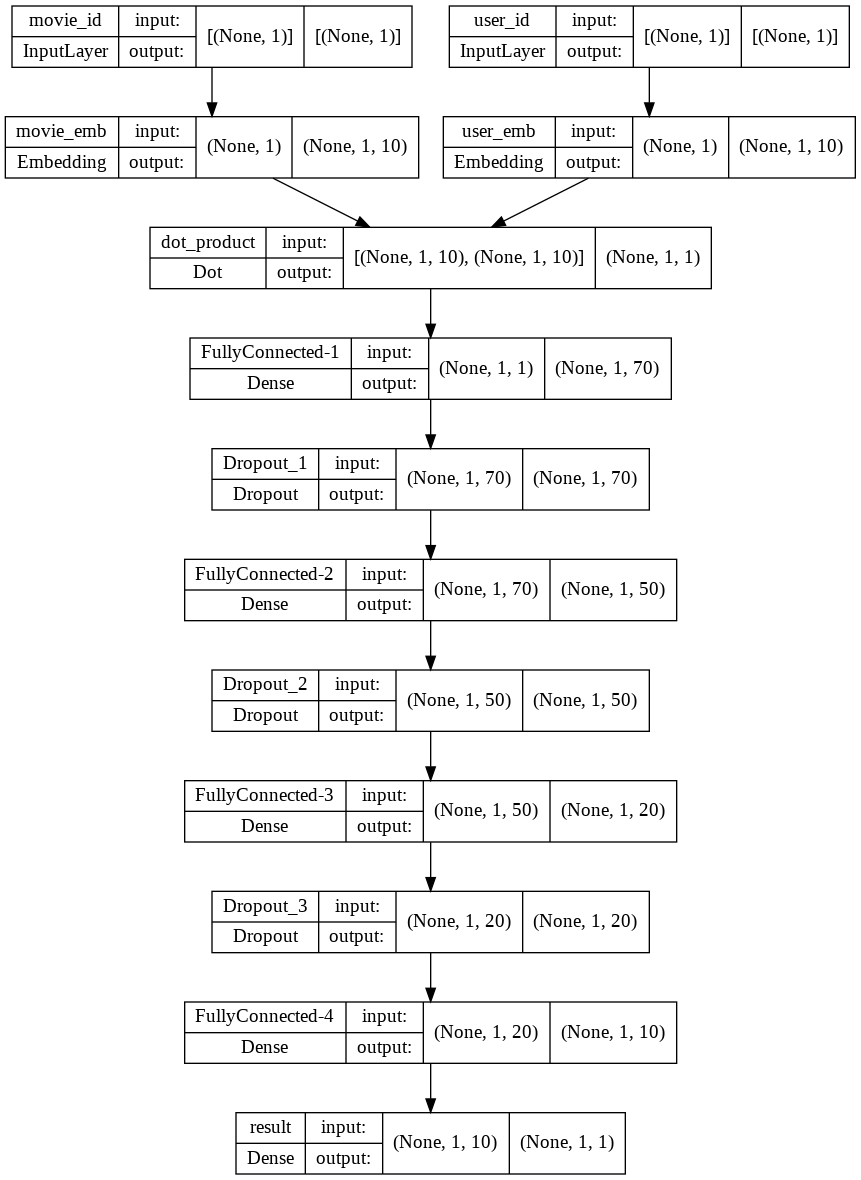

In [39]:
keras.utils.plot_model(model, show_shapes=True)

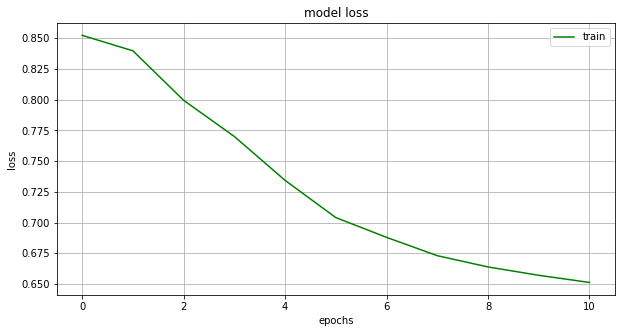

In [40]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

Evaluation

In [41]:
TEST_USER_ID = 200
TEST_MOVIE_ID = 123

In [42]:
MOVIE_EMBEDDING_LIST = []
MOVIE_EMBED_MAP = collections.defaultdict()

In [43]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
def tsne_plot(model, MOVIE_EMBEDDING_LIST, size = NUM_MOVIES):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(MOVIE_EMBEDDING_LIST[:size])
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    labels = list(range(0,size))
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')
    plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


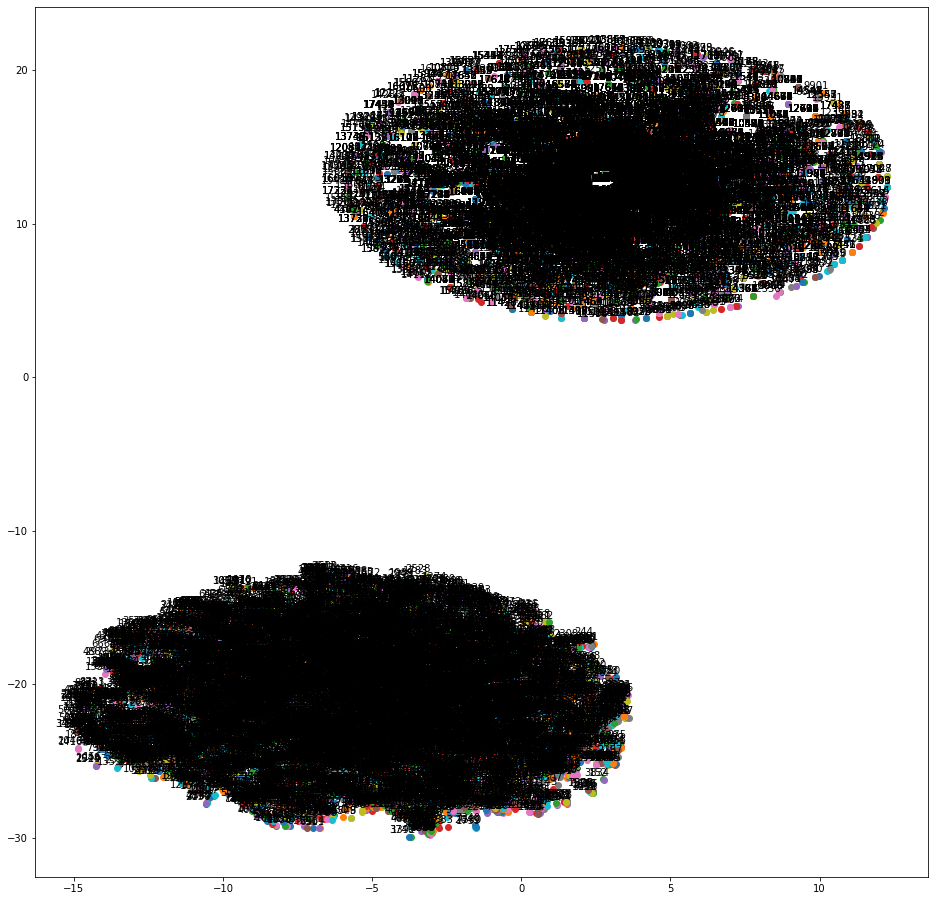

In [46]:
tsne_plot(model, MOVIE_EMBEDDING_LIST)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


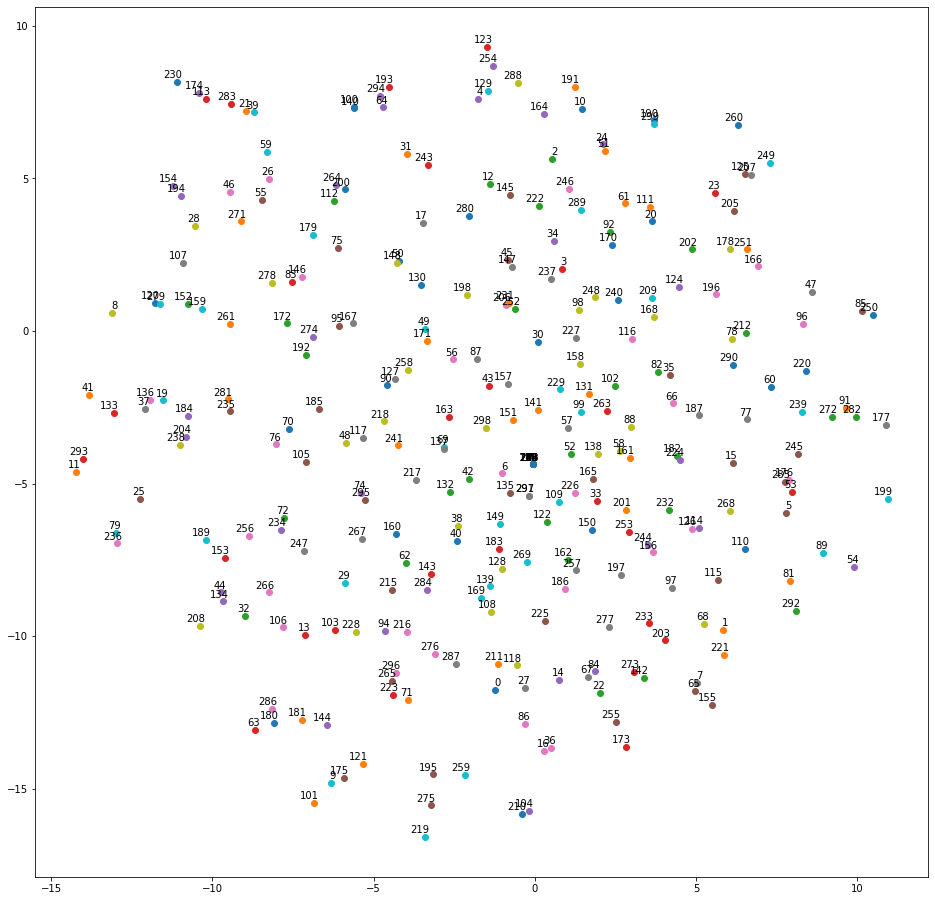

In [47]:
tsne_plot(model, MOVIE_EMBEDDING_LIST, 300)


In [48]:
knn_train_label = UNIQUE_MOVIE_IDS


In [49]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(MOVIE_EMBEDDING_LIST, knn_train_label)

KNeighborsClassifier(n_neighbors=11)

In [56]:
def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['movieId'])
    return df_indices.merge(movies,on='movieId',how='inner',suffixes=['_u', '_m'])['title']
    

In [51]:
TEST_USER_ID


200

In [55]:
movies = pd.read_csv("/content/train/movie.csv")

In [52]:
user_embedding = user_model.predict([TEST_USER_ID]).reshape(1,-1)[0]


In [57]:
recommend_movies(user_embedding)


0                      Midnight Dancers (Sibak) (1994)
1                                     Ned Kelly (1970)
2    Night of the Shooting Stars (Notte di San Lore...
3                                       Camilla (1994)
4                                   Big Trouble (1986)
5                                 On Any Sunday (1971)
6                         East-West (Est-ouest) (1999)
7                           Cinderella Story, A (2004)
8                           Conan the Destroyer (1984)
9                     Painted Fire (Chihwaseon) (2002)
Name: title, dtype: object